In [1]:
import numpy as np
import time
import torch
import torch.backends.cudnn as cudnn
import json
import os
# from data.dataset import GLDDataset 
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
# from data.dataset_contra import GLDDataset 
# from efficientnet_pytorch.model_e3 import EfficientNet
from torch.utils.data import DataLoader, RandomSampler, DistributedSampler, SequentialSampler
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from torchvision import transforms
from PIL import Image



In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='0'
model = EfficientNet.from_pretrained('efficientnet-b0',num_classes=10)
model_path = 'You model path'
print('Loading model from ', model_path)
checkpoint = torch.load(model_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.cuda()
model.eval()
index_feat_list = []
test_feat_list = []
num_workers = 4

Loaded pretrained weights for efficientnet-b0
Loading model from  You model path


In [3]:
class GLDV2(Dataset):

    def __init__(self, stage: str, inferance=True):
        self.stage = stage
        self.df = read_csv(stage)
        self.df.drop(self.df.filter(regex="Unname"), axis=1, inplace=True)
        self.label_list = self.df.landmark_id.tolist()
        self.namelist = [i.split('\\')[-1] for i in self.df.anchor.tolist()]
        print(f'shape of df is {len(self.df)}, stage is {stage}')
        self.s3path = 'You s3 path '
        self.my_transformer = transforms.Compose([
          transforms.Resize((224,224)),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, index):
        label = self.df.iloc[index]['landmark_id']
        name = self.namelist[index]
        anchor = self.df.iloc[index]['anchor'].split('\\')
        anchor_class = anchor[1]
        anchor_filen = anchor[2].split('.')[0].lower()
        if self.stage == 'index':     
            anchor_image = 'You train path' + name[0] +'/' + name[1] +'/' + name[2] +'/' +anchor_filen+'.jpg'
        else:
            anchor_image = 'You test path' + anchor_filen+'.jpg'
        anchor_im = Image.open(anchor_image).convert('RGB')
#         anchor_im = cv2.imread(anchor_image)
#         anchor_im = cv2.cvtColor(anchor_im, cv2.COLOR_BGR2RGB)
        transformed_anchor_im = self.my_transformer(anchor_im)
        return transformed_anchor_im 

    def __len__(self):
        return len(self.df)


def read_csv(stage):

    if stage == 'public':
        df = pd.read_csv('You public.csv path')
    elif stage == 'private':
        df = pd.read_csv('You private.csv path')
    elif stage == 'public_private':
        df = pd.read_csv('You public_private.csv path')
    elif stage == 'index':
        df = pd.read_csv('You index.csv path')

    else:
        raise ValueError(f'not supported stage{stage}')
    return df

In [4]:
test_dataset = GLDV2('public_private')
index_dataset = GLDV2('index')

# query_dataloader = DataLoader(query_dataset, batch_size=500, shuffle=False)
# index_dataloader = DataLoader(index_dataset, batch_size=500, shuffle=False)

shape of df is 1000, stage is public_private
shape of df is 100000, stage is index


In [5]:
# index_dataset = GLDDataset(root='train path', input_size=224, subset='index')
# test_dataset = GLDDataset(root='test path', input_size=224, subset='test')
index_dataloader = DataLoader(
                                    index_dataset,
                                    # sampler=train_sampler,
                                    batch_size=384,
                                    shuffle=False,
                                    num_workers=num_workers,
                                    drop_last=False,
                                    pin_memory=True
                                    # worker_init_fn=_worker_init_fn_()
                                    )


In [6]:
test_dataloader = DataLoader(
                                test_dataset,
                                # sampler=test_sampler,
                                batch_size=384,
                                shuffle=False,
                                num_workers= num_workers,
                                drop_last=False,
                                pin_memory=True
                                # worker_init_fn=_worker_init_fn_()
                                )

In [7]:
with torch.no_grad():
    # for epoch in range(args.start_epoch, args.epochs):
    for i_batch, data in enumerate(index_dataloader):
        print('{}/{}'.format(i_batch, len(index_dataloader)))
        img = data.cuda()
        # label = data['label']
        feat = model.extract_features(img).view(img.size(0), 1280,-1).mean(2)
        index_feat_list.append(feat.detach().cpu())
    for i_batch, data in enumerate(test_dataloader):
        print('{}/{}'.format(i_batch, len(test_dataloader)))
        img = data.cuda()
        feat = model.extract_features(img).view(img.size(0), 1280,-1).mean(2)
        test_feat_list.append(feat.detach().cpu())

0/261
1/261
2/261
3/261
4/261
5/261
6/261
7/261
8/261
9/261
10/261
11/261
12/261
13/261
14/261
15/261
16/261
17/261
18/261
19/261
20/261
21/261
22/261
23/261
24/261
25/261
26/261
27/261
28/261
29/261
30/261
31/261
32/261
33/261
34/261
35/261
36/261
37/261
38/261
39/261
40/261
41/261
42/261
43/261
44/261
45/261
46/261
47/261
48/261
49/261
50/261
51/261
52/261
53/261
54/261
55/261
56/261
57/261
58/261
59/261
60/261
61/261
62/261
63/261
64/261
65/261
66/261
67/261
68/261
69/261
70/261
71/261
72/261
73/261
74/261
75/261
76/261
77/261
78/261
79/261
80/261
81/261
82/261
83/261
84/261
85/261
86/261
87/261
88/261
89/261
90/261
91/261
92/261
93/261
94/261
95/261
96/261
97/261
98/261
99/261
100/261
101/261
102/261
103/261
104/261
105/261
106/261
107/261
108/261
109/261
110/261
111/261
112/261
113/261
114/261
115/261
116/261
117/261
118/261
119/261
120/261
121/261
122/261
123/261
124/261
125/261
126/261
127/261
128/261
129/261
130/261
131/261
132/261
133/261
134/261
135/261
136/261
137/261
138/26

In [8]:
import csv
from itertools import islice
from collections import defaultdict
from collections import Counter
import numpy as np
import torch.nn.functional as F
import cv2 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

In [9]:
def map_at_k(y_true, y_denominator, y_pred):
    """
    y_true : ndarray of shape  (n_test_image, n_true_label)
        The true label of query images.  正确的标签
    y_denominator : ndarray of shape   (n_test_image)
    这个类别在index数据集中有几张图像
    y_pred : ndarray of shape  (n_test_image, top_k)
        The predicted label of query images. 预测结果
    """
    # Check format of input
    assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray)
    assert y_true.ndim == 2 and y_pred.ndim == 2

    k = y_pred.shape[1]
    is_correct_list = []

    # In case of multiple true labels, check correctness of each label
    # Then use np.logical_or to conbine
    for i in range(y_true.shape[1]):
        is_correct = y_true[:, i][:, np.newaxis] == y_pred
        is_correct_list.append(is_correct)
    is_correct_mat = np.logical_or.reduce(np.array(is_correct_list))

    # Compute map
    cumsum_mat = np.apply_along_axis(np.cumsum, axis=1, arr=is_correct_mat)
    arange_mat = np.expand_dims(np.arange(1, k + 1), axis=0)
    ap_100_list = np.sum((cumsum_mat / arange_mat) * is_correct_mat, axis=1) / y_denominator

    return np.mean(ap_100_list), ap_100_list

In [10]:
index_list_csv = 'You index.csv path'
test_list_csv = 'You public_private.csv path'

In [11]:
index_list = []
index_class_list = []
test_list = []
test_class_list = []
with open(index_list_csv)as f:
    f_csv = csv.reader(f)
    for row in islice(f_csv, 1, None):
        label = int(row[1])
        img_id = row[2].split('\\')[-1].split('.')[0]
        # img_path = os.path.join(, img_name[0], img_name[1], img_name[2], img_name)
        index_list.append((img_id, label))
        index_class_list.append(label)
index_class_counter = Counter(index_class_list)

In [12]:
max_len_test = 0
with open(test_list_csv)as f:
    f_csv = csv.reader(f)
    for row in islice(f_csv, 1, None):
        label = row[1]
        label = [int(x) for x in label.split()]
        img_id = row[2].split('\\')[-1].split('.')[0]
        # img_path = os.path.join(, img_name[0], img_name[1], img_name[2], img_name)
        max_len_test = len(label) if len(label)>max_len_test else max_len_test
        test_list.append((img_id, label))
        test_class_list.append(label)
print(max_len_test)

4


In [13]:
index_feats_all = torch.cat(index_feat_list, 0).cuda()
test_feats_all = torch.cat(test_feat_list, 0).cuda()


In [14]:
with torch.no_grad():
    # for i in range(test_feats_all.size(0)):
    index_feats_all = F.normalize(index_feats_all, dim=1)
    test_feats_all=  F.normalize(test_feats_all, dim=1)
    # torch.cosine_similarity(p1.reshape(-1), p2.reshape(-1), dim=0)
    similarity_matrix = torch.mm(test_feats_all, index_feats_all.transpose(0, 1))

# print(similarity_matrix)

In [15]:
index_root = 'You train image path' 
test_root = 'You test image path' 
score, idx = similarity_matrix.topk(100, dim=1, largest=True, sorted=True)
# print(values)
# print(idx)
sift = cv2.SIFT_create(contrastThreshold=0.0)
bf = cv2.BFMatcher(cv2.NORM_L2)
ori_score = score.detach().cpu().numpy()
idx_list = idx.detach().cpu().numpy() #1000, 100
new_idx_list = np.zeros_like(idx_list)

In [16]:
for test_id in range(len(test_list)): 
    print(test_id)
    index_ids = idx_list[test_id]
    test_img_id = test_list[test_id][0]
    test_img_name = test_img_id+'.jpg'
    test_img_path = os.path.join(test_root, test_img_name)
    img = Image.open(test_img_path)
    if img.mode != 'RGB':
        img = img.convert("RGB") 
    img = transforms.Resize((224, 224), Image.BILINEAR)(img)
    # img = transforms.CenterCrop(self.input_size)(img)
    img = transforms.ToTensor()(img)
    img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
    test_img = img.unsqueeze(0).cuda()
    with torch.no_grad():
        test_patch_feat = model.extract_features(test_img)
    test_patch_feat = test_patch_feat.view(1, 1280, 49).permute(0,2,1).reshape(1*49, 1280)
    test_patch_feat = F.normalize(test_patch_feat, dim=1)
    # index_feat_t100 = []
    t100_good  = defaultdict()
    index_img_path_list = []
    for k, idx in enumerate(index_ids):
        img_id = index_list[idx][0]
        img_name = img_id + '.jpg'
        index_img_path = os.path.join(index_root, img_name[0], img_name[1], img_name[2], img_name)
        img = Image.open(index_img_path)
        if img.mode != 'RGB':
            img = img.convert("RGB") 
        img = transforms.Resize((224, 224), Image.BILINEAR)(img)
        # img = transforms.CenterCrop(self.input_size)(img)
        img = transforms.ToTensor()(img)
        img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
        index_img = img.unsqueeze(0).cuda()
        with torch.no_grad():
            index_patch_feat = model.extract_features(index_img)
        index_patch_feat = index_patch_feat.view(1, 1280, 49).permute(0,2,1).reshape(49, 1280)
        index_patch_feat = F.normalize(index_patch_feat, dim=1)
        similarity = torch.mm(test_patch_feat, index_patch_feat.transpose(0, 1))  #bs, num_index 
        similarity = similarity.view(1,49,1,49).permute(0,2,1,3) # bs, bs2, 49, 49 
        # similarity,_ = torch.max(similarity.reshape(bs,bs2, 49*49), 2)
        similarity, _ = torch.max(similarity, 3)
        similarity = similarity.mean(2)
        similarity = similarity.detach().cpu().numpy()[0,0]
        t100_good[idx] = 0.6*similarity + 0.4*ori_score[test_id][k] # 0.3 0.7     0.4 0.6 
    idx_ori_list = dict(sorted(t100_good.items(), key=lambda x:x[1], reverse=True)).keys()
    new_idx_list[test_id] = list(idx_ori_list)
score_list = score.detach().cpu().numpy()
index_class_list = np.array(index_class_list)
y_pred = index_class_list[new_idx_list] #1000, 100
print(y_pred[0])

0


/home/bo/work/venv/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [17]:
print(idx_ori_list)

dict_keys([47156, 47141, 47152, 47136, 47146, 47158, 38353, 47137, 22721, 47138, 62962, 47144, 91195, 47285, 40864, 25253, 47157, 51384, 82251, 50335, 47283, 27627, 22049, 89487, 40865, 84320, 82258, 42987, 38133, 69765, 82263, 82252, 49427, 89488, 25255, 47147, 40863, 47153, 74195, 74314, 36518, 67240, 47504, 64247, 83813, 92080, 82248, 68887, 47145, 93430, 9559, 55127, 15366, 40869, 9753, 79283, 32535, 47143, 46261, 72065, 25380, 40006, 9754, 57224, 25107, 84086, 16343, 70272, 9562, 82245, 87744, 77168, 83803, 15988, 47155, 68985, 4825, 81618, 83089, 20862, 56519, 32268, 2089, 9755, 23605, 74047, 81614, 47133, 9560, 38963, 16251, 30901, 25924, 24100, 74640, 42079, 46189, 46203, 97456, 51251])


In [18]:
y_denominator_list = []
index_class_counter = dict(index_class_counter)
# print(index_class_counter)
for item in  test_class_list:
    cnt = 0
    for label in item:
        cnt += index_class_counter[label]
#     print(item, cnt)
    y_denominator_list.append(cnt)
y_denominator = np.array(y_denominator_list)

In [19]:
y_true_list = []
for item in test_class_list:
    new_item = [x for x in item]
    k =  max_len_test - len(item)
    for y in range(k):
        new_item += [item[0]]
    y_true_list.append(new_item)
y_true = np.array(y_true_list)
mAP, ap_list = map_at_k(y_true, y_denominator, y_pred)

In [20]:
print('* *mAP@100:', mAP)

* *mAP@100: 0.32999983831170515


In [21]:
len(y_true)

1000

In [22]:
y_pred[100]

array([146427, 146427, 146427, 146427, 146427, 146427, 146427, 116097,
       146427, 138332,  21329, 146427,  43118,  58179, 146427,  58179,
       121764,  22164, 201000,  76730, 143444, 146427, 165648,  25830,
       123010, 127803, 146427, 125343, 120841, 116097, 146427, 200566,
       146427, 116097, 193222, 195366, 120839,  70963,  98652,  24658,
        85647, 182618,  20500, 158355, 195366, 146427,  43118,  98652,
       138332, 113105, 146427,  22164,   5564, 123303, 159823,  96524,
        41225, 146427,  57437, 138332,  31030, 184883,  94542,  43762,
        91549,  97549, 157129,  65065, 191941,  22164, 189708, 134938,
       174986,  20103, 178209, 193419, 193003,  21158,  23580,  28366,
       170638,  65033, 181281,  14085,  70645,  22687,  65033, 190761,
        92860,  11390, 113589,  37345,   6370, 190761,   2414, 114261,
        67727,  85791, 133724, 178092])

In [23]:
def display_query_and_top_k_match(query_dataset, index_dataset, ranked_list, index, k=24, width=5):
    row = int((k+1)//width)
    k = row * width -1
    images = []
    top_k_indices = ranked_list[:,index]
    top_k_index = top_k_indices[:k]
    label = query_dataset.df.iloc[index]['landmark_id']
    name = query_dataset.namelist[index]
    
    query_img_path = '/home/bo/work/tianyi/dataset_original/test/' + name
    anchor_im = plt.imread(query_img_path.lower())
#     anchor_im = cv2.cvtColor(anchor_im, cv2.COLOR_BGR2RGB)
    print(query_img_path)
    fig = plt.figure(figsize=(10, row*3.3))
    a = plt.subplot(row, width, 1)
    plt.subplots_adjust(left=0.1, bottom = 0.1, right = 0.95, wspace = 0.1, hspace=0, top = 0.7)
    plt.imshow(anchor_im)
    a.set_title(f'Query image: {label}')
    a.set_xticks([])
    a.set_yticks([])
    
    for i in range(1,k+1):
        name = index_dataset.namelist[top_k_index[i-1]]
        index_img_path = '/home/bo/work/tianyi/dataset_original/train/' + name[0] +'/' + name[1] +'/' + name[2] +'/' + name
        anchor_im = plt.imread(index_img_path.lower())
#         anchor_im = cv2.cvtColor(anchor_im, cv2.COLOR_BGR2RGB)
        label = index_dataset.df.iloc[top_k_index[i-1]]['landmark_id']
        a = plt.subplot(row, width, i+1)
        plt.imshow(anchor_im)
        a.set_title(f'top{i}:{label}')
        a.set_xticks([])
        a.set_yticks([])
        
    plt.show()

In [24]:
import matplotlib.pyplot as plt

/home/bo/work/tianyi/dataset_original/test/3ed9f6f5fc837a28.jpg


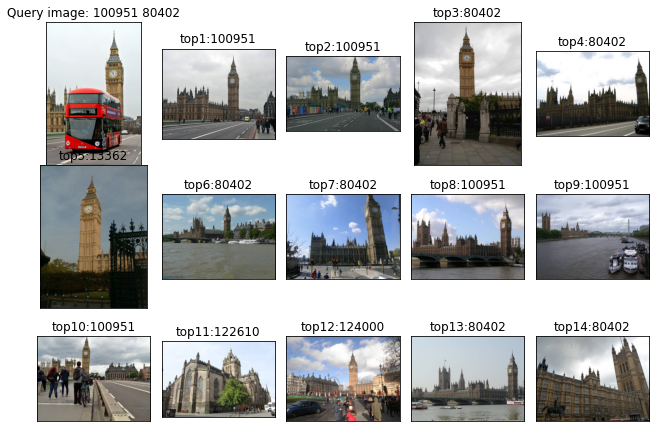

In [25]:
display_query_and_top_k_match(test_dataset, index_dataset, np.array(new_idx_list).T, 0, k=14)

/home/bo/work/tianyi/dataset_original/test/8d99133803e95dcd.jpg


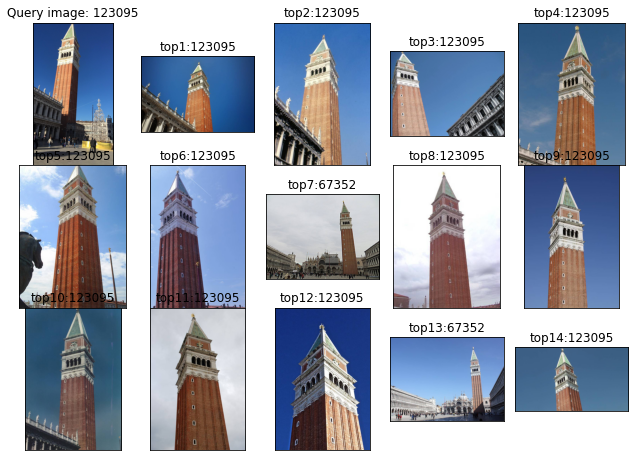

In [26]:
display_query_and_top_k_match(test_dataset, index_dataset, np.array(new_idx_list).T, 50, k=14)